In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import Normalize

from sklearn.datasets import fetch_openml, load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.metrics import median_absolute_error, PredictionErrorDisplay, RocCurveDisplay, PrecisionRecallDisplay, cohen_kappa_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.style.use("ggplot")

### **Regression Analysis**

In [4]:
# Ejercicio 1

In [5]:
survey = fetch_openml(name="cps_85_wages", as_frame=True, parser="auto")
print(survey.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

Determinants of Wages from the 1985 Current Population Survey

Summary:
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. We wish to determine (i) whether wages are related to these characteristics and (ii) whether there is a gender gap in wages.
Based on residual plots, wages were log-transformed to stabilize the variance. Age and work experience were almost perfectly correlated (r=.98). Multiple regression of log wages against sex, age, years of education, work experience, union membership, southern residence, and occupational status showed that these covariates were related to wages (pooled F test, 

In [6]:
X = survey.data
y = survey.target

In [7]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


In [9]:
cat_cols = [
    "SOUTH", "SEX", "UNION", "RACE", "OCCUPATION", "SECTOR", "MARR"
]

X[cat_cols].describe()

,SOUTH,SEX,UNION,RACE,OCCUPATION,SECTOR,MARR
count,534,534,534,534,534,534,534
unique,2,2,2,3,6,3,2
top,no,male,not_member,White,Other,Other,Married
freq,378,289,438,440,156,411,350


In [10]:
num_cols = [
    "EDUCATION", "EXPERIENCE", "AGE"
]

X[num_cols].describe()

,EDUCATION,EXPERIENCE,AGE
count,534.000000,534.000000,534.000000
mean,13.018727,17.822097,36.833333
std,2.615373,12.379710,11.726573
min,2.000000,0.000000,18.000000
25%,12.000000,8.000000,28.000000
50%,12.000000,15.000000,35.000000
75%,15.000000,26.000000,44.000000
max,18.000000,55.000000,64.000000


In [11]:
y.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [12]:
y.describe()

count    534.000000
mean       9.024064
std        5.139097
min        1.000000
25%        5.250000
50%        7.780000
75%       11.250000
max       44.500000
Name: WAGE, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

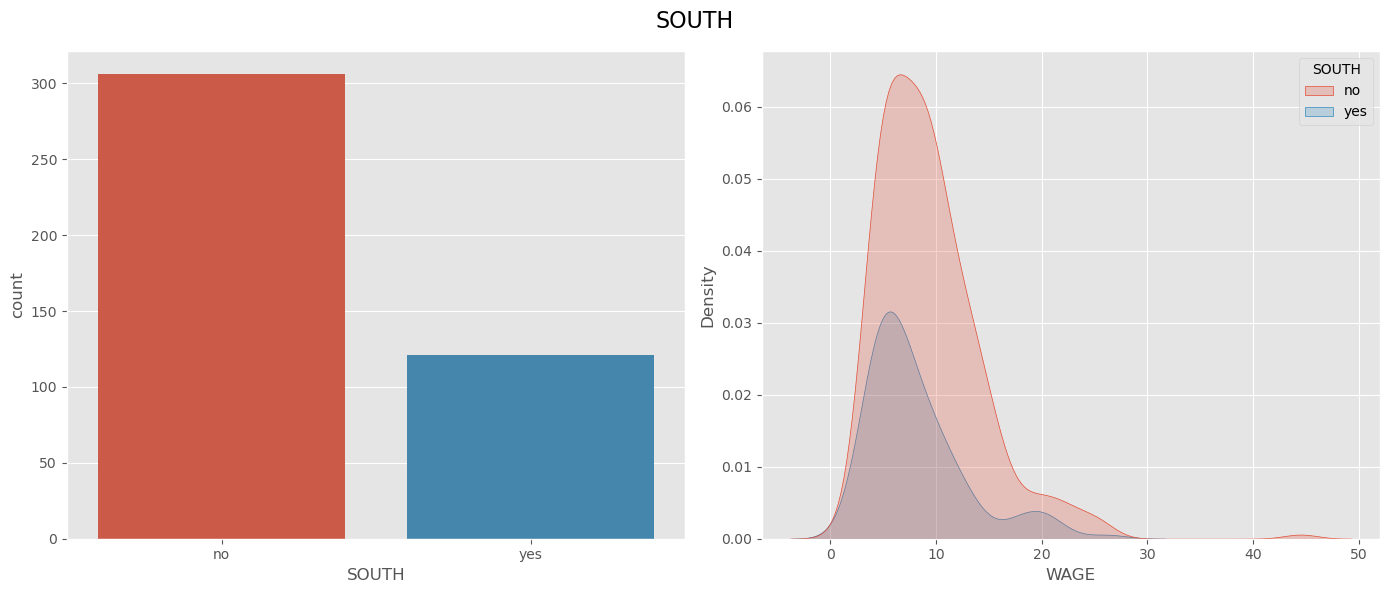

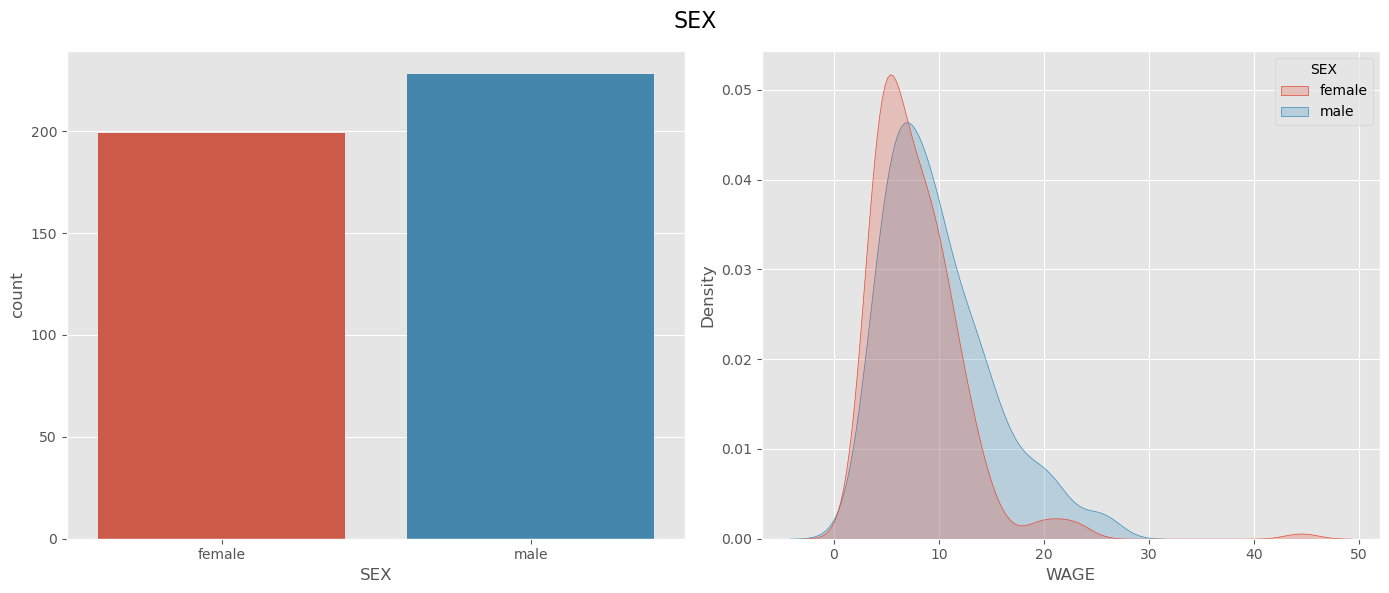

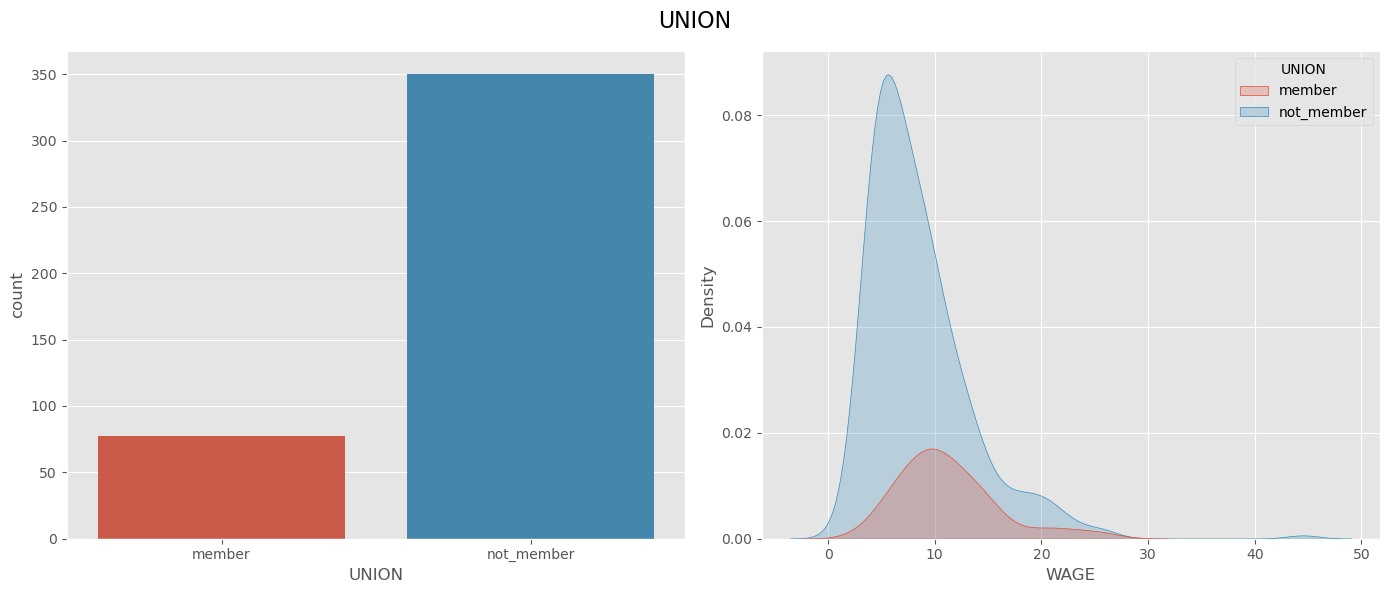

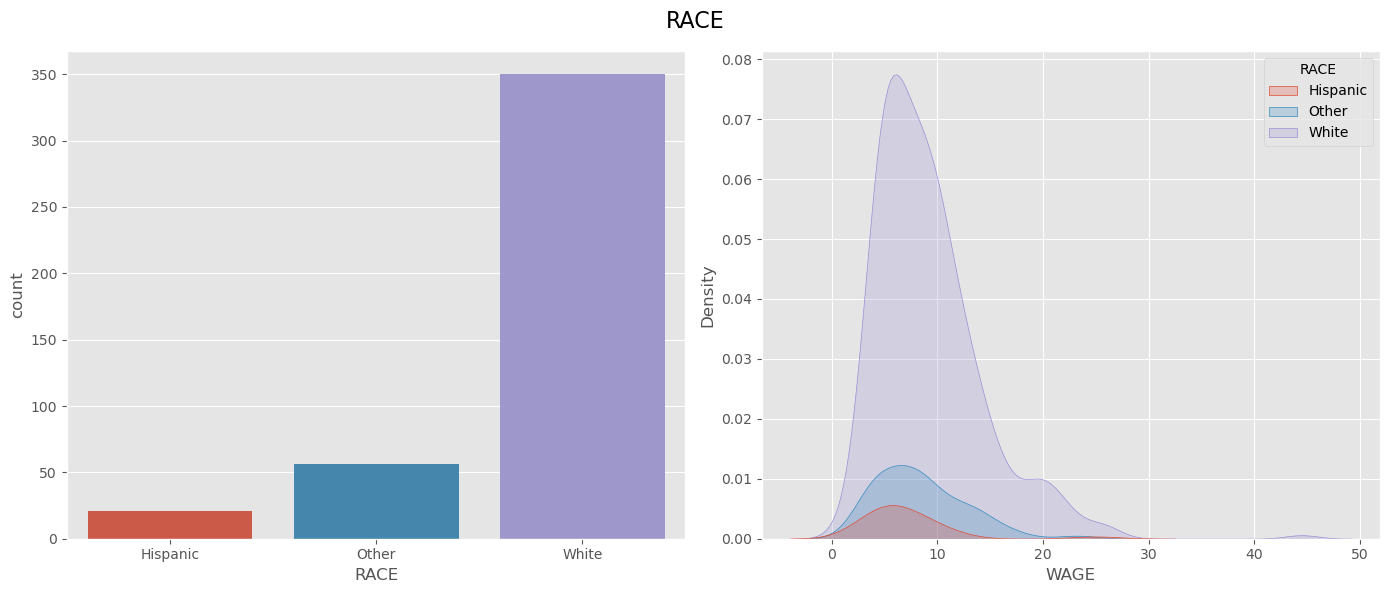

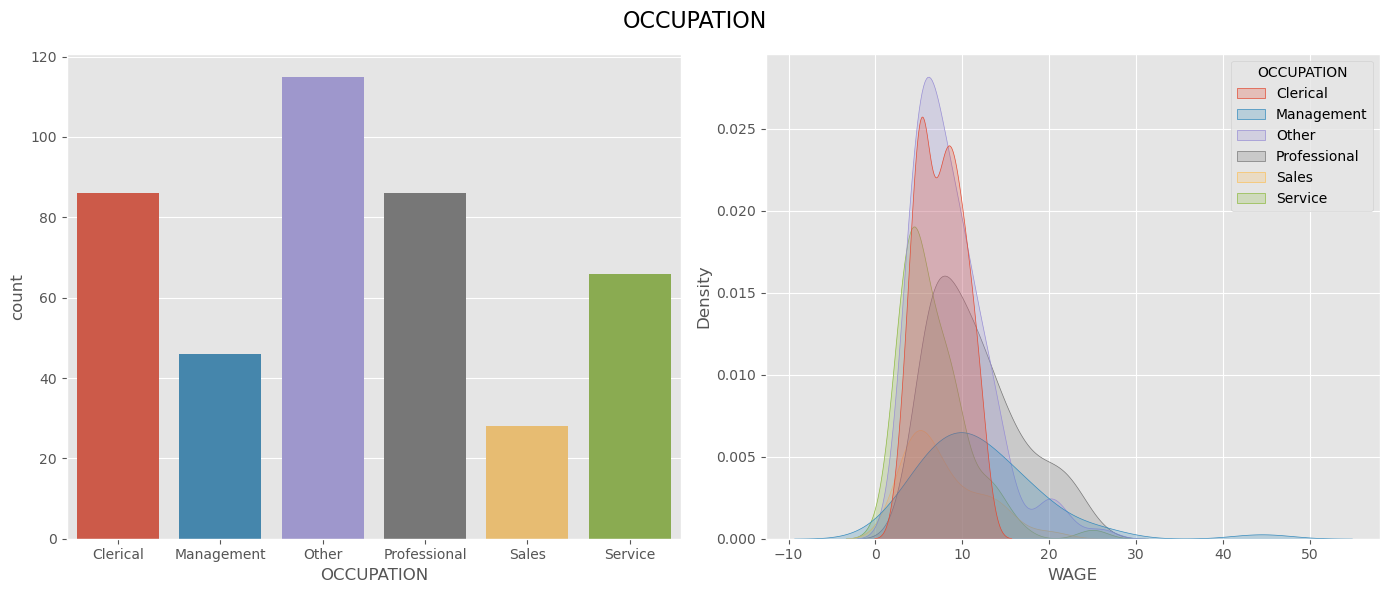

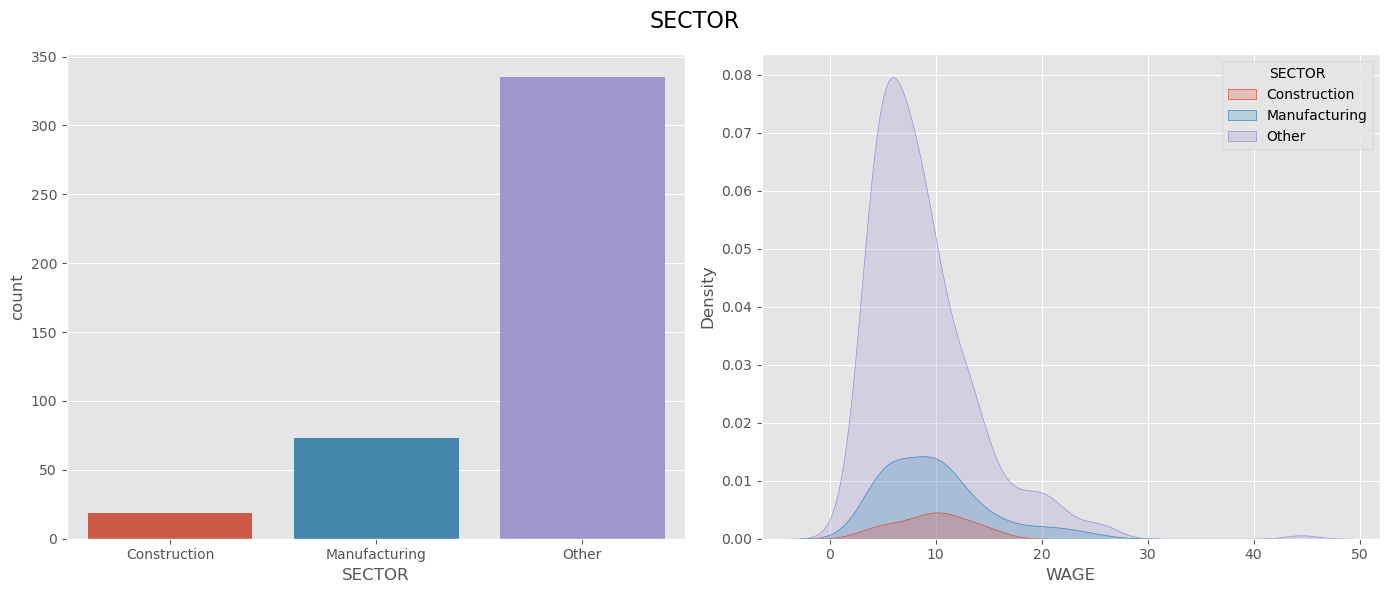

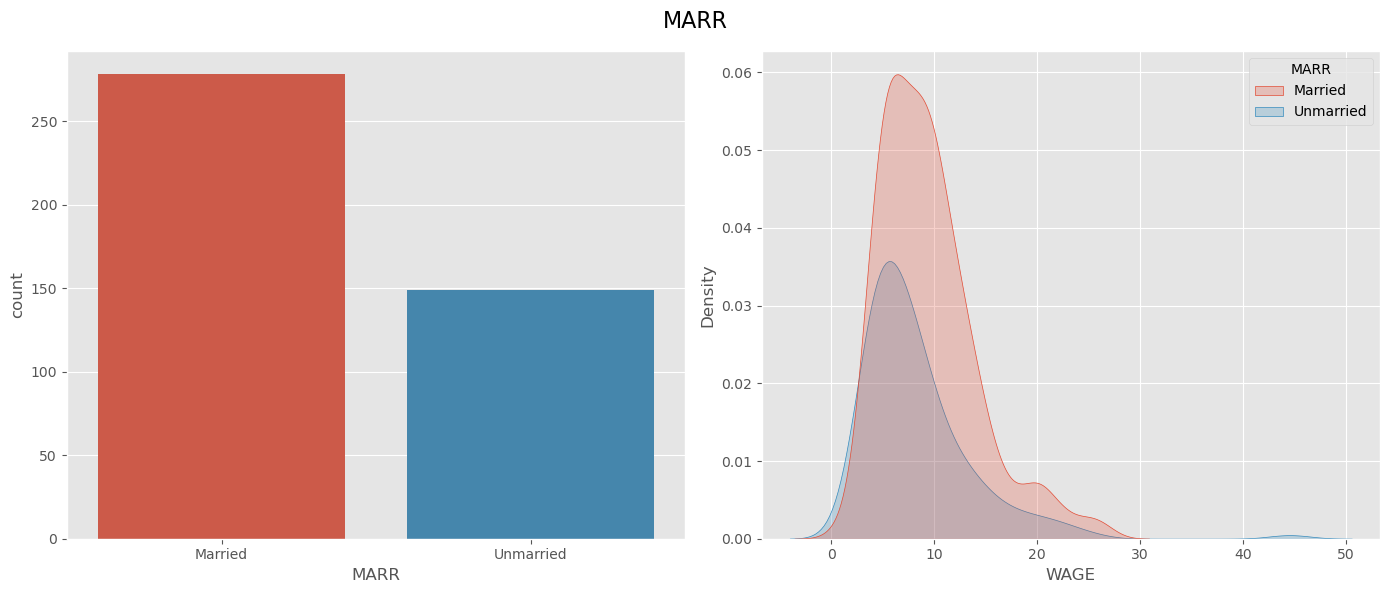

In [14]:
for c in cat_cols:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(c, fontsize=16)
    sns.countplot(X_train, x=c, ax=ax[0])
    sns.kdeplot(x=y_train, hue=X_train[c], fill=True)
    plt.tight_layout()
    plt.show()

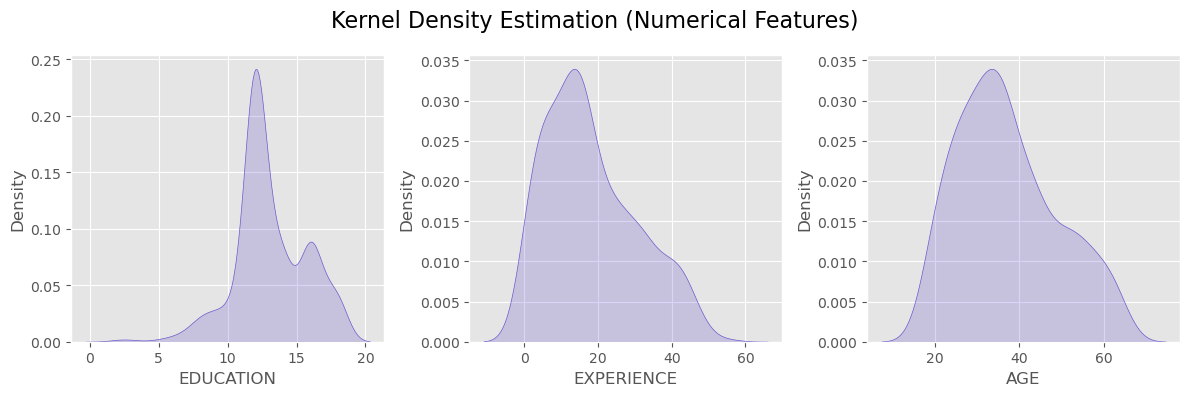

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle("Kernel Density Estimation (Numerical Features)", fontsize=16)
for i in range(3):
    sns.kdeplot(X_train, x=num_cols[i], fill=True, color="slateblue", ax=ax[i])
plt.tight_layout()
plt.show()

In [16]:
X_train[num_cols].corr()

,EDUCATION,EXPERIENCE,AGE
EDUCATION,1.000000,-0.336776,-0.134222
EXPERIENCE,-0.336776,1.000000,0.978140
AGE,-0.134222,0.978140,1.000000


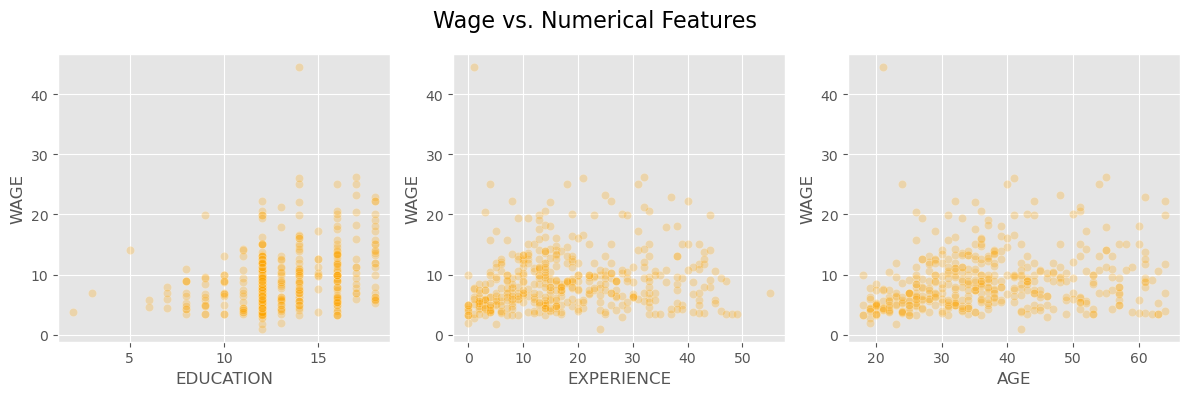

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.suptitle("Wage vs. Numerical Features", fontsize=16)
for i in range(3):
    sns.scatterplot(x=X_train[num_cols[i]], y=y_train, color="orange", alpha=0.25, ax=ax[i])
plt.tight_layout()
plt.show()

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ], verbose_feature_names_out=False
)

In [19]:
alphas = np.logspace(-10, 10, 21)

##### **Ridge Regression**

In [20]:
ridge = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas), 
        func=np.log10, 
        inverse_func=sp.special.exp10
    )
)
ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR']),
                                                 ('num', StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

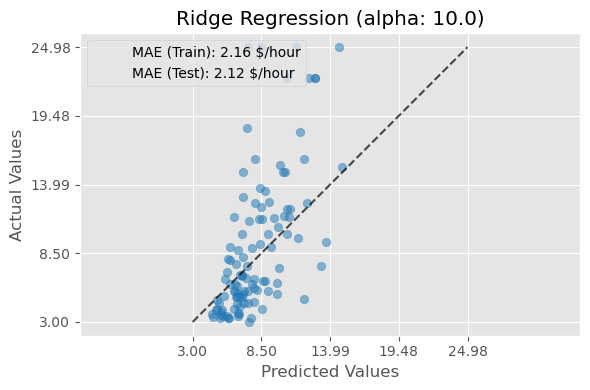

In [21]:
mae_train, mae_test = \
    median_absolute_error(y_train, ridge.predict(X_train)), median_absolute_error(y_test, ridge.predict(X_test))

scores = {
    "MAE (Train)": f"{mae_train:.2f} $/hour",
    "MAE (Test)": f"{mae_test:.2f} $/hour",
}

fig, ax = plt.subplots(figsize=(6, 4))

PredictionErrorDisplay.from_predictions(
    y_test, ridge.predict(X_test), kind="actual_vs_predicted", scatter_kwargs={"alpha": 0.5}, ax=ax
)

for key in scores.keys():
    ax.plot([], [], " ", label=f"{key}: {scores[key]}")

ax.set_title(f"Ridge Regression (alpha: {ridge[-1].regressor_.alpha_})")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")

ax.legend(loc="upper left")

plt.tight_layout()

plt.show()


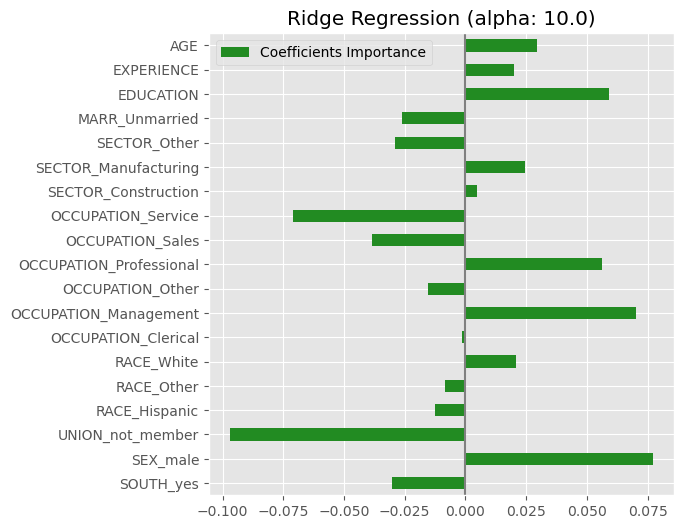

In [22]:
pd.DataFrame(
    ridge[-1].regressor_.coef_,
    columns=["Coefficients Importance"],
    index=ridge[:-1].get_feature_names_out(),
).plot(kind="barh", color="forestgreen", figsize=(6, 6))
plt.axvline(0, color="gray")
plt.title(f"Ridge Regression (alpha: {ridge[-1].regressor_.alpha_})")
plt.show()

##### **Lasso Regression**

In [23]:
lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100000), 
        func=np.log10, 
        inverse_func=sp.special.exp10)
)
lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR']),
                                                 ('num', StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=LassoCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                                                              max_iter=100000)))])

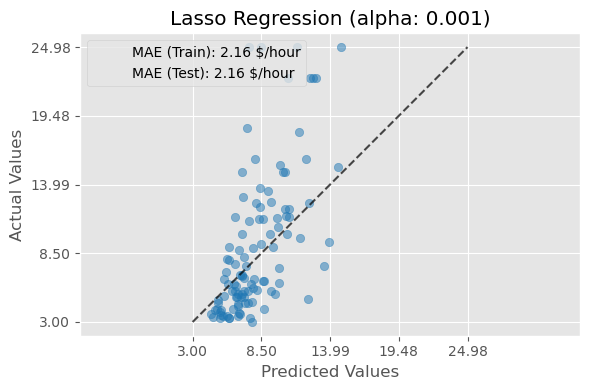

In [24]:
mae_train, mae_test = \
    median_absolute_error(y_train, lasso.predict(X_train)), median_absolute_error(y_test, lasso.predict(X_test))

scores = {
    "MAE (Train)": f"{mae_train:.2f} $/hour",
    "MAE (Test)": f"{mae_test:.2f} $/hour",
}

fig, ax = plt.subplots(figsize=(6, 4))

PredictionErrorDisplay.from_predictions(
    y_test, lasso.predict(X_test), kind="actual_vs_predicted", scatter_kwargs={"alpha": 0.5}, ax=ax
)

for key in scores.keys():
    ax.plot([], [], " ", label=f"{key}: {scores[key]}")

ax.set_title(f"Lasso Regression (alpha: {lasso[-1].regressor_.alpha_})")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")

ax.legend(loc="upper left")

plt.tight_layout()

plt.show()

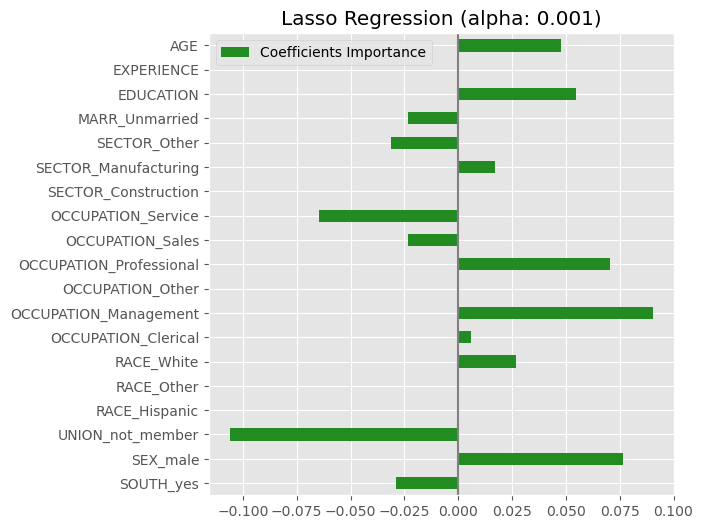

In [25]:
pd.DataFrame(
    lasso[-1].regressor_.coef_,
    columns=["Coefficients Importance"],
    index=ridge[:-1].get_feature_names_out(),
).plot(kind="barh", color="forestgreen", figsize=(6, 6))
plt.axvline(0, color="gray")
plt.title(f"Lasso Regression (alpha: {lasso[-1].regressor_.alpha_})")
plt.show()

### **Support Vector Machines (SVMs)**

In [26]:
# Ejercicio 3

In [27]:
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [28]:
X = iris.data[:, :2]
y = iris.target

In [29]:
models = (
    SVC(C=1, kernel="linear"),
    LinearSVC(C=1, max_iter=10000),
    SVC(C=1, kernel="rbf", gamma=0.7),
    SVC(C=1, kernel="poly", degree=3, gamma="auto")
)
models = (model.fit(X, y) for model in models)

In [30]:
titles = (
    "SVC with Linear Kernel",
    "LinearSVC (Linear Kernel)",
    "SVC with RBF Kernel",
    "SVC with Polynomial (degree 3) Kernel"
)

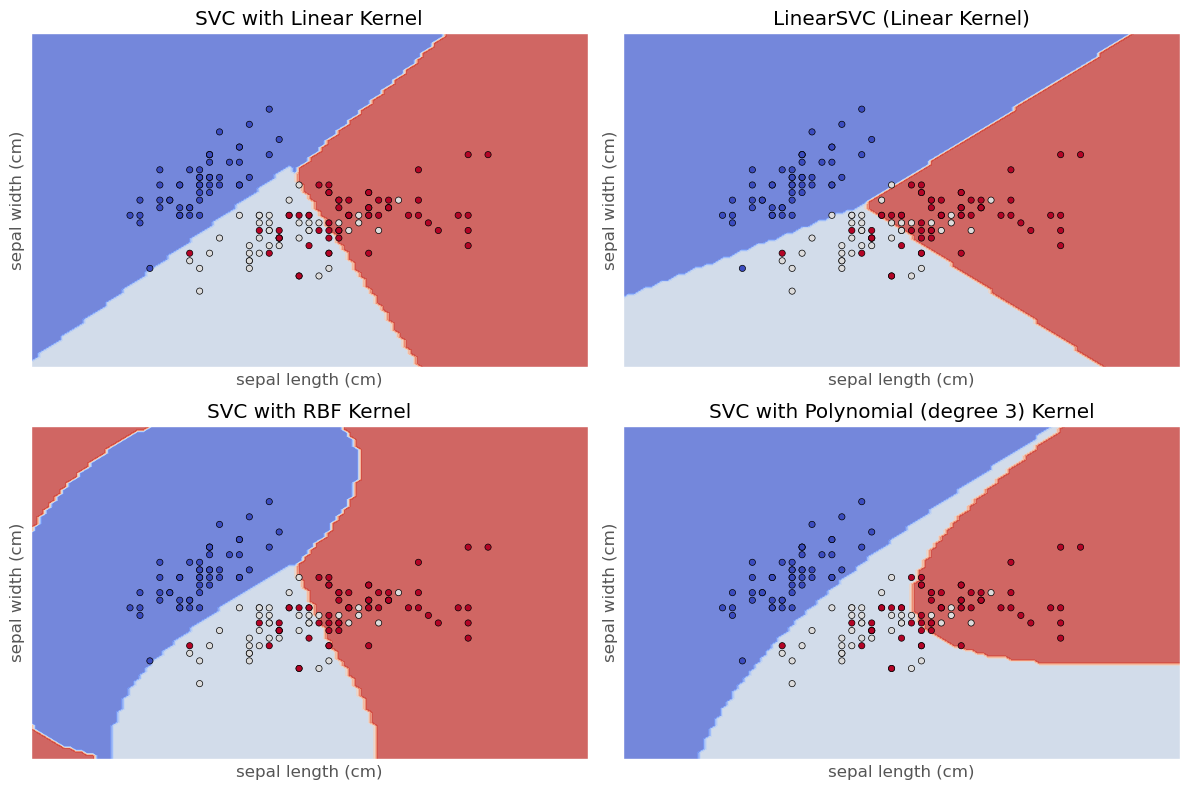

In [31]:
fig, sub = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for model, title, ax in zip(models, titles, sub.flatten()):

    DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.75,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

plt.show()

In [32]:
# Ejercicio 4

In [33]:
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [34]:
X = iris.data
y = iris.target

X_2d = X[:, :2][y != 0]
y_2d = y[y != 0] - 1

In [35]:
scaler = StandardScaler()

X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

In [36]:
C_vals = np.logspace(-2, 10, 13)
gamma_vals = np.logspace(-9, 3, 13)

grid = GridSearchCV(
    SVC(), 
    param_grid={
        "C": C_vals, 
        "gamma": gamma_vals
    }, 
    cv=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


In [37]:
C_vals_2d = [1e-2, 1, 1e2]
gamma_vals_2d = [1e-1, 1, 1e1]

classifiers = []
for C in C_vals_2d:
    for gamma in gamma_vals_2d:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

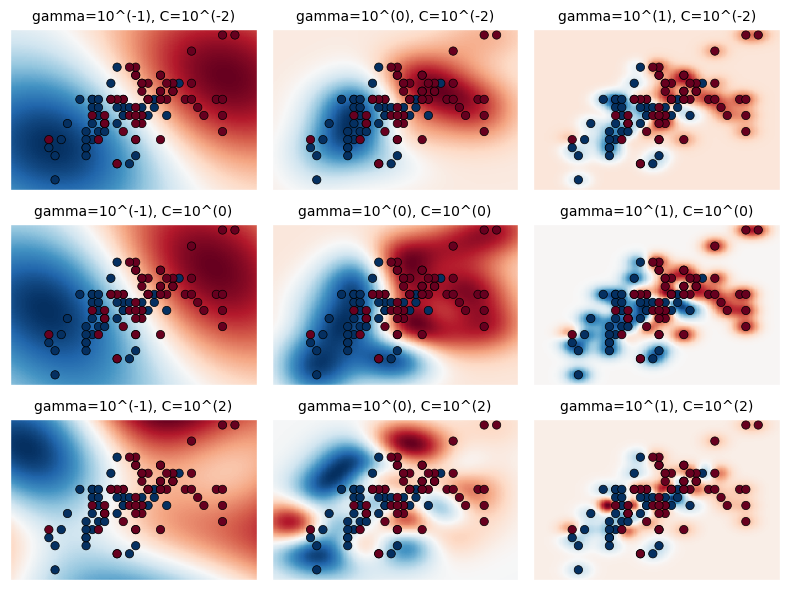

In [38]:
plt.figure(figsize=(8, 6))

xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))

for k, (C, gamma, clf) in enumerate(classifiers):

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(len(C_vals_2d), len(gamma_vals_2d), k + 1)
    
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")

    plt.title("gamma=10^(%d), C=10^(%d)" % (np.log10(gamma), np.log10(C)), size="medium")
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

plt.show()

In [39]:
class MidpointNormalize(Normalize):
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

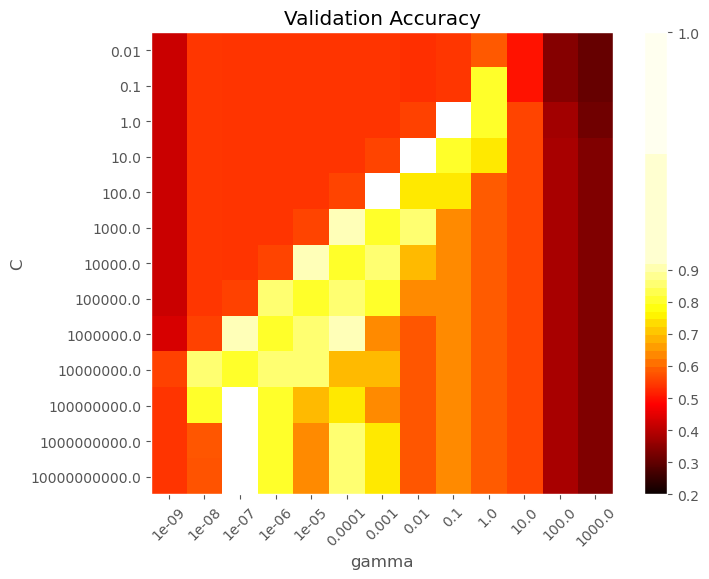

In [40]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_vals), len(gamma_vals))

plt.figure(figsize=(8, 6))

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)

plt.colorbar()

plt.title("Validation Accuracy")
plt.xlabel("gamma")
plt.ylabel("C")

plt.xticks(np.arange(len(gamma_vals)), gamma_vals, rotation=45)
plt.yticks(np.arange(len(C_vals)), C_vals)

plt.grid(False)

plt.show()

### **ROC Curve - Precision-Recall Curve**

In [41]:
# Ejercicio 5

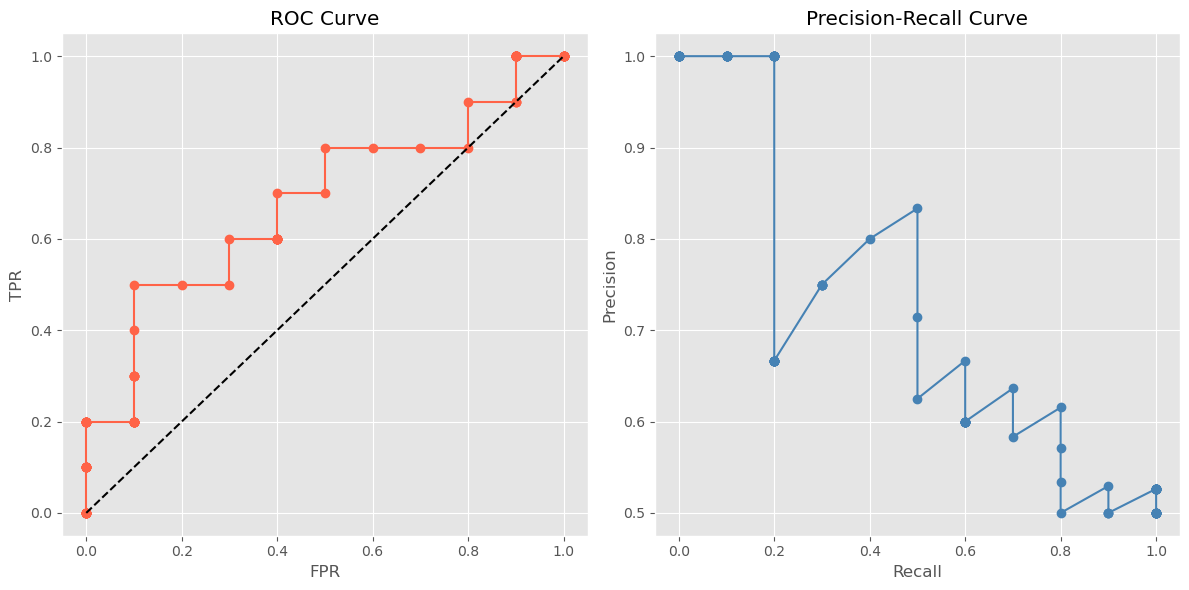

In [42]:
y = np.array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])
S = np.array([0.90, 0.80, 0.70, 0.60, 0.55, 0.54, 0.53, 0.52, 0.51, 0.50, 0.40, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.30, 0.10])

T = np.linspace(0, 1, 100)[::-1]

FPR = []
TPR = []

Recall = []
Precision = []

P = np.sum(y == 1)
N = np.sum(y == 0)

for threshold in T:

    y_pred = (S >= threshold).astype(int)
    
    TP = np.sum((y_pred == 1) & (y == 1))
    FP = np.sum((y_pred == 1) & (y == 0))
    FN = np.sum((y_pred == 0) & (y == 1))
    TN = np.sum((y_pred == 0) & (y == 0))

    FPR.append(FP / N if N else 0)
    TPR.append(TP / P if P else 0)

    Recall.append(TP / P if P else 0)
    Precision.append(TP / (TP + FP) if (TP + FP) else 1)

FPR = [0.0] + FPR + [1.0]
TPR = [0.0] + TPR + [1.0]

Recall = [0.0] + Recall
Precision = [1.0] + Precision

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(FPR, TPR, color="tomato", marker="o")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.subplot(1, 2, 2)
plt.plot(Recall, Precision, color="steelblue", marker='o')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()

plt.show()

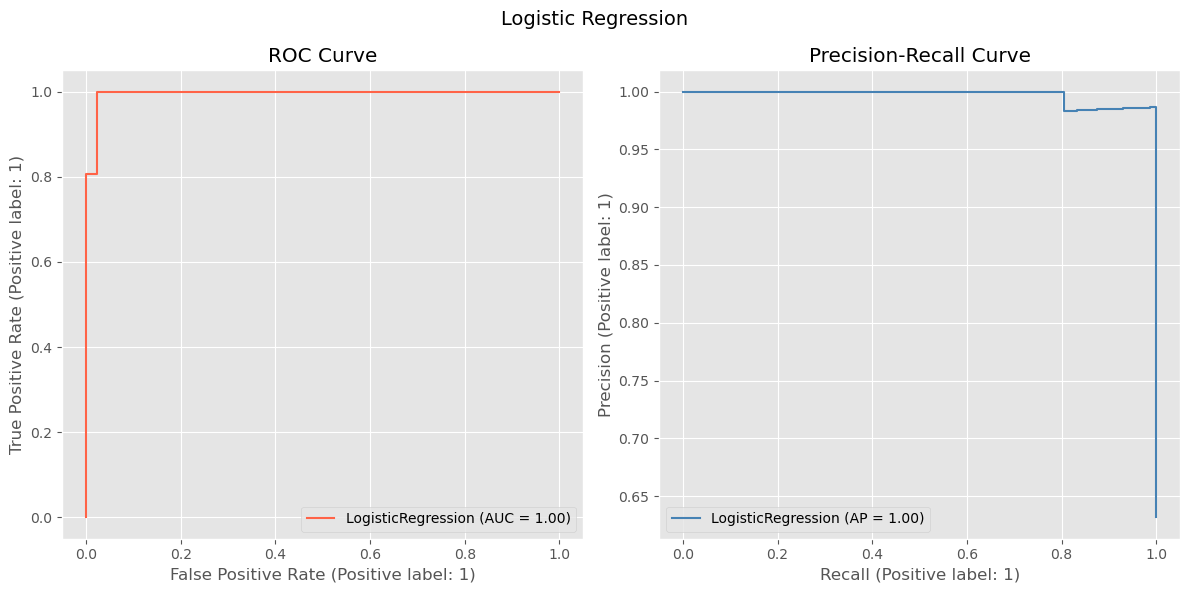

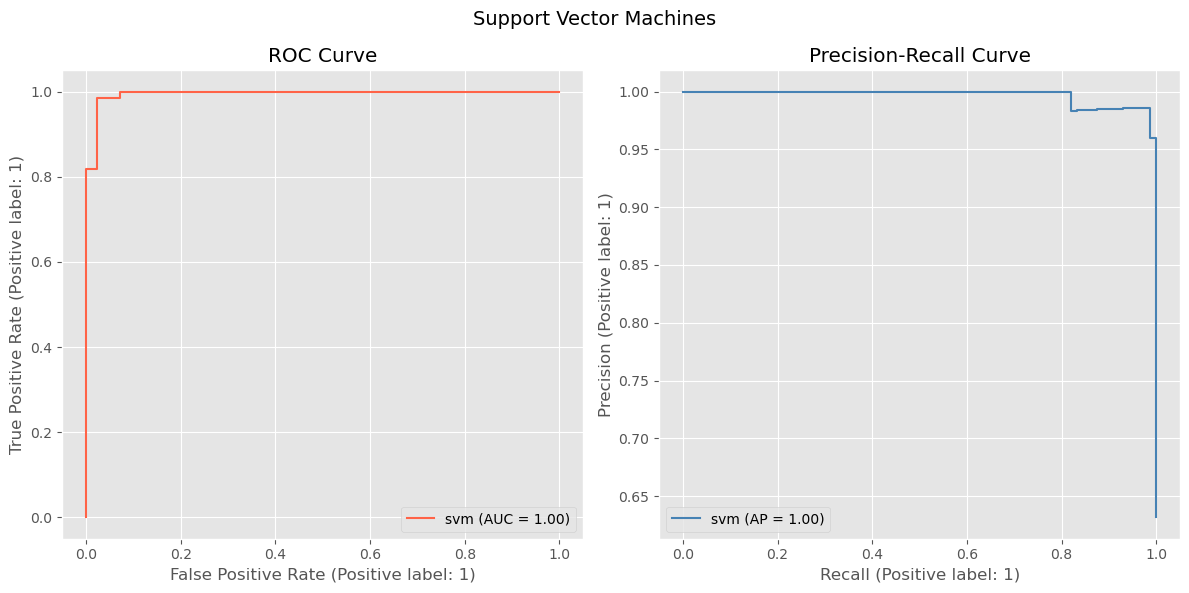

In [43]:
# Data Preparation
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

scaler = StandardScaler()
scaler.fit(X_train)

Z_train, Z_test = scaler.transform(X_train), scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(Z_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Logistic Regression", fontsize=14)
RocCurveDisplay.from_estimator(logreg, Z_test, y_test, ax=ax[0], color="tomato")
ax[0].set_title("ROC Curve")
PrecisionRecallDisplay.from_estimator(logreg, Z_test, y_test, ax=ax[1], color="steelblue")
ax[1].set_title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

# Support Vector Machines
svm = SVC()
svm.fit(Z_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Support Vector Machines", fontsize=14)
RocCurveDisplay.from_estimator(svm, Z_test, y_test, ax=ax[0], color="tomato", name="svm")
ax[0].set_title("ROC Curve")
PrecisionRecallDisplay.from_estimator(svm, Z_test, y_test, ax=ax[1], color="steelblue", name="svm")
ax[1].set_title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

### **Cohen's Kappa**

In [44]:
# Ejercicio 6

In [45]:
# Confusion Matrix:
#         T    F
#     T  25   35
#     F   5   35

annotator1 = [1]*25 + [1]*35 + [0]*5 + [0]*35
annotator2 = [1]*25 + [0]*35 + [1]*5 + [0]*35

kappa = cohen_kappa_score(annotator1, annotator2)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.2593
